## Imports

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io
import itertools as it
import scipy.special as psi
plt.style.use('classic')
import seaborn as sns
import pandas as pd
import math as mt
import time
import sys

sys.path.insert(1, '/rds/general/user/lr4617/home/4th_Year_Project/Final_Year_Project/')

from scipy.io import loadmat
from scipy import stats
from numpy.random import seed
from numpy.random import rand
from scipy.integrate import quad
from scipy.io import savemat
from tempfile import TemporaryFile
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.decomposition import KernelPCA
from mpl_toolkits import mplot3d
from mPE_fn import mPE_
from scipy.spatial import distance
from scipy.stats import entropy
from mPE_ultis import integrand, ubble, array_list, permutation

In [29]:
##################################### CHANGE TRAJECTORY NUMBER HERE #####################################
traj_n = 2
#########################################################################################################

##################################### CHANGE TRAJECTORY MODE HERE #######################################
mode = 'drug'
#########################################################################################################

## Load and Clean Data - V2

In [30]:
# load entire high-dimensional trajectory
path = '/rds/general/user/lr4617/home/4th_Year_Project/CAPTURE_rat_multidimensional/raw_data/' + str(mode) + '/traj_' + str(traj_n) + '/trajectories_na/'
trajectories = os.listdir(path)
f_s = 300
# removing NaN columns
nan_cols = []
for i, time_bin in enumerate(trajectories):
    if time_bin != 'behavs':
        trajectory = loadmat(path + time_bin)
        trajectory = trajectory['trajectory'] 
        for i in range(trajectory.shape[1]):
            if np.isnan(trajectory[:, i]).all():
                nan_cols.append(i)

### Helper function

In [31]:
def rolling_mean(x, window, overlapping=True):
    '''
    input:
        x      - input sequence
        window - rolling window
        
    returns:
        y      - moving averaged sequence
    '''
        
    ## assuming that there are more observations than variables:
    if np.max(x.shape)> x.shape[0]:
        x=x.transpose()
        
    y = np.zeros((x.shape))
    for i in range(0, x.shape[0] - window):
        y[i, :] = np.mean(x[i:i+window, :], axis=0)
        
    y[x.shape[0]-window:x.shape[0]-1, :] = x[x.shape[0]-window:x.shape[0]-1, :]
    
    return y

In [32]:
nan_cols = np.asarray(nan_cols)
a = 0

if nan_cols.size > 0:
    if len(np.where(nan_cols==nan_cols[0])[0])*3 == len(nan_cols):
        all_trajectories = np.zeros((trajectory.shape[0]*int(len(trajectories)), trajectory.shape[1]-len(nan_cols)))
else:
    all_trajectories = np.zeros((trajectory.shape[0]*int(len(trajectories)), trajectory.shape[1]))

for i, time_bin in enumerate(trajectories):
    if time_bin != 'behavs':
        trajectory = loadmat(path + time_bin)
        trajectory = trajectory['trajectory'] 
        if nan_cols.size > 0:
            trajectory = np.delete(trajectory, nan_cols, 1)
            
        idx_2 = i*trajectory.shape[0]
        window = f_s
        mov_av_traj = rolling_mean(trajectory, window)
        all_trajectories[idx_2:idx_2+trajectory.shape[0], 0:all_trajectories.shape[1]] = mov_av_traj
        
# convert nan to number when not it is a sparse recurrence (not an entire column)
all_trajectories = np.nan_to_num(all_trajectories)
print('Data points in standard trajectory: ', all_trajectories.shape)

Data points in standard trajectory:  (3348000, 60)


## Dimensionality Reduction: PCA

0.8576020735772676


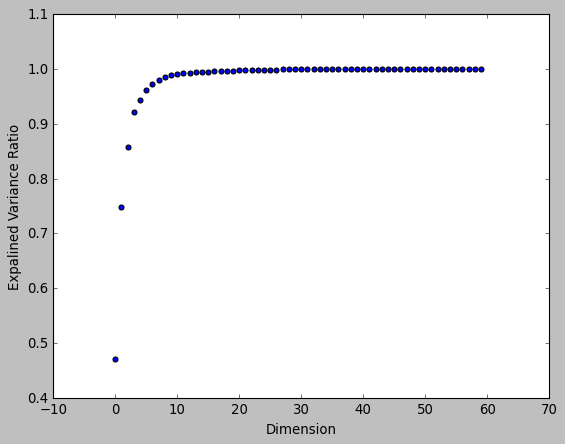

In [44]:
# inspecting inter-dimensional variance with PCA
pca = PCA()
pca.fit(all_trajectories)

explained_var_plot = [np.sum(pca.explained_variance_ratio_[0:i+1]) for i in range(len(pca.explained_variance_ratio_))]
plt.scatter(np.arange(all_trajectories.shape[1]), explained_var_plot)
print(sum(pca.explained_variance_ratio_[0:3]))
plt.ylabel('Expalined Variance Ratio')
plt.xlabel('Dimension')
plt.show()

# reduce data according to explained variance values using linear PCA
pca = PCA(n_components=3)
reduced_traj = pca.fit_transform(all_trajectories)

## mPE analysis

### Helper functions

In [45]:
def get_mPE_matrix(reduced_traj, bins_number, traj_number, orders=[3], random=False):
    mPE_vector = np.zeros((bins_number, traj_number, len(orders)))
    traj_length = int((reduced_traj.shape[0]/bins_number)/traj_number)
    print(traj_length)
    for a, order in enumerate(orders):
        for i in range(bins_number):
            idx_1 = 0
            idx = 0
            for j in range(0, traj_length*traj_number, traj_length):
                if random:
                    idx_1 = np.random.randint(np.max(reduced_traj.shape) - traj_length)
                    traj = reduced_traj[idx_1: idx_1 + traj_length]
                else:
                    idx_1 = i*traj_number*traj_length 
                    traj = reduced_traj[idx_1 + j: idx_1 + j + traj_length]
                    
                if traj.shape[0]>0:
                    [HH, _]=mPE_(traj, order)
                    mPE_vector[i, idx, a] = HH
                idx +=1
    return mPE_vector

In [46]:
def probability(*argv):
    '''
    input: 
        - 1D sequence of rv observations
    return: 
        - probability vector
    '''
    n_args = len(argv)
    if n_args == 1:
        sequence = argv[0]
        decimals = 1
        size = 0
        
    if n_args == 2:
        sequence = argv[0]
        decimals = argv[1]
        size = 0
    
    if n_args == 3:
        sequence = argv[0]
        decimals = argv[1]
        size = argv[2]
    
    if len(sequence.shape) > 1 and (sequence.shape[0] < sequence.shape[1]):
        sequence = np.transpose(sequence)
    
    # round input sequence to avoid sparse probability vector
    sequence = np.round(sequence, decimals)
    unique = np.unique(sequence, axis=0)
    n_unique = len(unique)

    # fill probability vector
    if size == 0:
        prob_vector = np.zeros((n_unique, 1))
    else:
        prob_vector = np.zeros((size, 1))

    for row in sequence:
        if len(sequence.shape) > 1:
            occurrences = len(np.where(np.all(np.isclose(sequence, row), axis=1))[0])
            idx = np.where(np.all(np.isclose(unique, row), axis=1))[0][0]
        else:
            occurrences = len(np.where(np.isclose(sequence, row))[0])
            idx = np.where(np.isclose(unique, row))[0][0]
            
        if prob_vector[idx] == 0:
            prob_vector[idx] = occurrences/(sequence.shape[0])
            
    return prob_vector

In [ ]:
mu, sigma = 5, 0.5 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)

prob_s = probability(s)



### Control analysis

In [47]:
# Take random trajectories and check that they have approximately the same mPE
fs = 300
minutes = 5
bin_length = fs*60*minutes
unit_length = 1500
traj_number = int(bin_length/unit_length)
bins_number = int(reduced_traj.shape[0]/bin_length)
orders = [3]
random = True

rand_idxs = np.random.randint(reduced_traj.shape[0], size=(bin_length*2))
reduced_traj_sample = reduced_traj[rand_idxs, :]
print(reduced_traj_sample.shape)
bins_number = int(reduced_traj_sample.shape[0]/bin_length)
print(reduced_traj_sample.shape, bins_number, traj_number)

# calculate mPE for any 2 random trajectories
mPE_vector = get_mPE_matrix(reduced_traj_sample, bins_number, traj_number, orders, random)

(180000, 3)
(180000, 3) 2 60
1500


(5.0, 5.5)

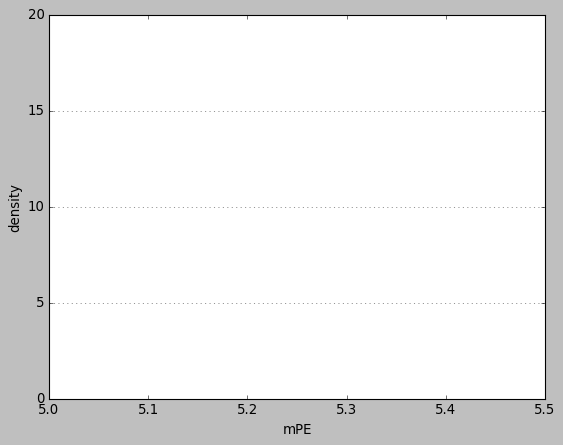

In [48]:
# plotting mpE of the first bin 
order_n = 0
fig = plt.figure()
c = ['r', 'b']
# plotting mPE continuous distribution as a function of time 
    
ax = sns.kdeplot(mPE_vector[0, :, order_n], color=c[0])
ax = sns.kdeplot(mPE_vector[1, :, order_n], color=c[1])

plt.grid(axis='y', alpha=0.75)
plt.xlabel('mPE')
plt.ylabel('density')
plt.xlim([5,5.5])

In [49]:
## Retrieve maxiumum number of elements based on a raw decimal discretization
truncation_decimal = 3
print(mPE_vector)

min_ = float('inf')
max_ = float('-inf')
for order in range(mPE_vector.shape[2]):
    for bin_ in range(mPE_vector.shape[0]):
        for traj in range(mPE_vector.shape[1]):
            if mPE_vector[bin_, traj, order] > max_:
                max_ = mPE_vector[bin_, traj, order]
            elif mPE_vector[bin_, traj, order] < min_:
                min_ = mPE_vector[bin_, traj, order]

min_ = (round(min_ * 10**(truncation_decimal)))/(10**truncation_decimal)
max_ = (round(max_ * 10**(truncation_decimal)))/(10**truncation_decimal)
max_size = int((max_ - min_)/(1/(10**truncation_decimal)))

## Get probability vectors
prob1 = probability(mPE_vector[0, :, 0], truncation_decimal, max_size)
prob2 = probability(mPE_vector[1, :, 0], truncation_decimal, max_size)

## Evaluation    
significance_lev = 0.01
js_distance = distance.jensenshannon(prob1, prob2)
[_, p_value] = stats.ks_2samp(mPE_vector[0, :, 0], mPE_vector[1, :, 0])
if p_value >= significance_lev:
    print("same distribution")
else:
    print("different distribution")

print(p_value)

[[[7.623164  ]
  [7.6057047 ]
  [7.62650228]
  [7.63414553]
  [7.61900728]
  [7.59417858]
  [7.59010839]
  [7.61050518]
  [7.56074203]
  [7.60388112]
  [7.62605806]
  [7.60202789]
  [7.61636498]
  [7.65979383]
  [7.58651989]
  [7.58709823]
  [7.64002193]
  [7.62018789]
  [7.63531281]
  [7.62309071]
  [7.63591353]
  [7.60355265]
  [7.61813551]
  [7.57861949]
  [7.59513554]
  [7.58866248]
  [7.59946122]
  [7.61046218]
  [7.58498006]
  [7.58047405]
  [7.59841253]
  [7.58645273]
  [7.59998586]
  [7.570205  ]
  [7.62044792]
  [7.59489699]
  [7.58443271]
  [7.58484043]
  [7.65004903]
  [7.62431617]
  [7.62901446]
  [7.61261813]
  [7.5954925 ]
  [7.61052165]
  [7.61902605]
  [7.6270492 ]
  [7.61764481]
  [7.61652917]
  [7.6294306 ]
  [7.56267038]
  [7.61737419]
  [7.60143223]
  [7.59385101]
  [7.59467868]
  [7.61379762]
  [7.62831915]
  [7.62633447]
  [7.63596219]
  [7.60440233]
  [7.61332422]]

 [[7.58528387]
  [7.56687507]
  [7.63610628]
  [7.59961986]
  [7.61662764]
  [7.60766874]
  [7.606

### Entropy analysis

In [50]:
# Take random trajectories and check that they have approximately the same mPE
fs = 300
minutes = 5
bin_length = fs*60*minutes
unit_length = 1500
traj_number = int(bin_length/unit_length)
bins_number = int(reduced_traj.shape[0]/bin_length)
orders = [3]

# calculate mPE for any 2 random trajectories
mPE_vector = get_mPE_matrix(reduced_traj, bins_number, traj_number, orders, random)

1508


## Results Evaluation

/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be rem

Text(0, 0.5, 'std mPE')

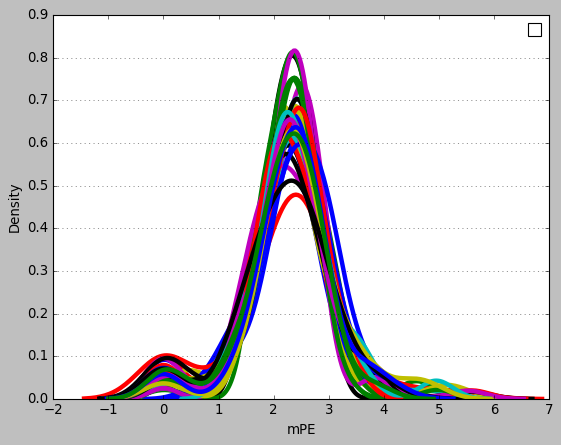

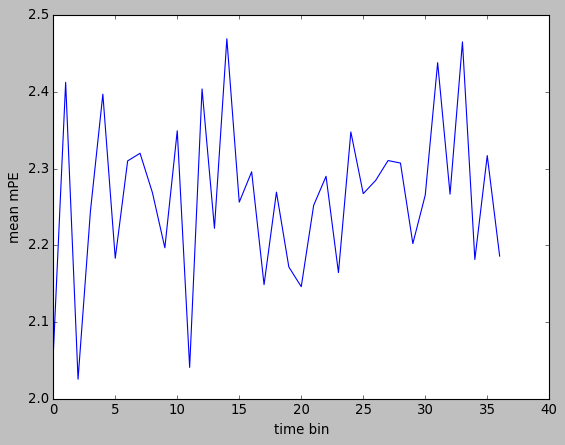

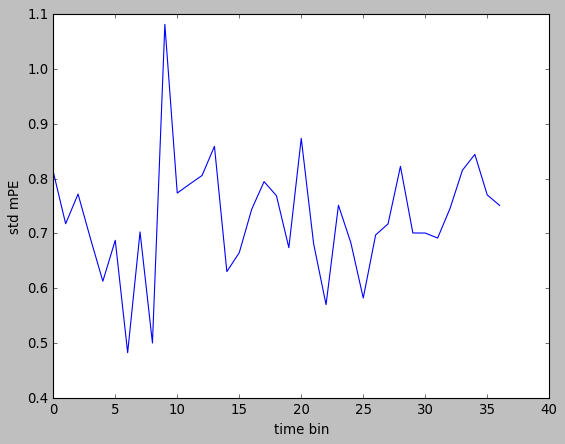

In [63]:
# entropy distribution visualization

# plotting mpE of the first bin 
order_n = 0
fig = plt.figure()

# plotting mPE continuous distribution as a function of time 
means = np.zeros(((bins_number),1))
stds = np.zeros(((bins_number),1))
n = 32
for bin_n in range(bins_number):
    means[bin_n] = np.mean(mPE_vector[bin_n, :, order_n])
    stds[bin_n] = np.std(mPE_vector[bin_n, :, order_n])
    ax = sns.distplot(mPE_vector[bin_n, :, order_n], hist=False, kde=True, 
                      bins=0.1, 
                      hist_kws={'edgecolor':'black'},
                      kde_kws={'linewidth': 4})

plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.xlabel('mPE')
plt.ylabel('Density')

fig = plt.figure()
plt.plot(np.arange(bins_number), means)
plt.xlabel('time bin')
plt.ylabel('mean mPE')

fig = plt.figure() 
plt.plot(np.arange(bins_number), stds)
plt.xlabel('time bin')
plt.ylabel('std mPE')

0.11976314781726739
0.9994855219552188
0.8132812991497796
0.027628318680706847
4 cacca
0.8132812991497796
0.37773061749650066
0.11976314781726739
0.37773061749650066


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


0.18205691052851009
0.046660870723173625
10 cacca
0.8132812991497796
0.046660870723173625
12 cacca
0.9284371795338576
0.004627144187221645
14 cacca
0.11976314781726739
0.2671202776187836


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


0.8132812991497796
0.51301231282104
0.37773061749650066
0.8132812991497796
0.51301231282104
0.2671202776187836
0.8132812991497796
0.027628318680706847
24 cacca
0.18205691052851009


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be rem

0.18205691052851009
0.046660870723173625
27 cacca
0.046660870723173625
28 cacca
0.37773061749650066
0.11976314781726739
0.11976314781726739
0.51301231282104
0.07607524222884415
33 cacca
0.2671202776187836
0.11976314781726739


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'P-Value')

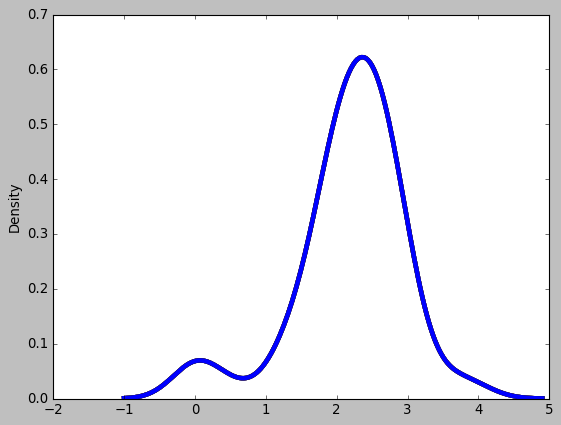

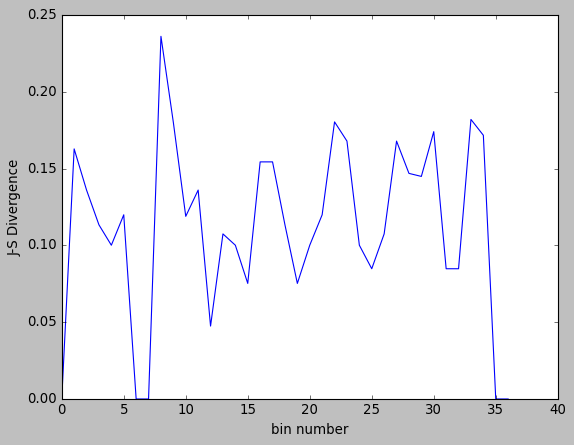

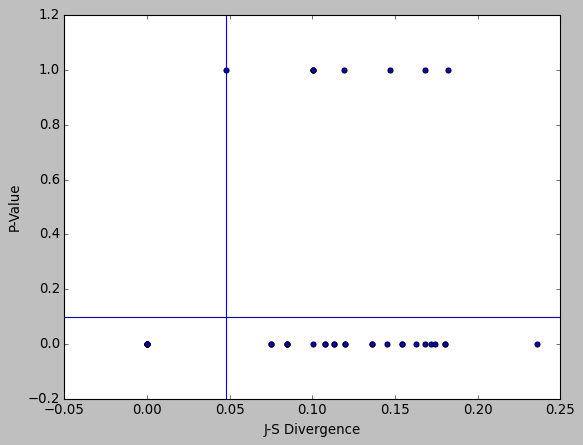

In [65]:
######### get discretized vocubulary for probability distribution #########
min_ = float('inf')
max_ = float('-inf')
for order in range(mPE_vector.shape[2]):
    for bin_ in range(mPE_vector.shape[0]):
        for traj in range(mPE_vector.shape[1]):
            if mPE_vector[bin_, traj, order] > max_:
                max_ = mPE_vector[bin_, traj, order]
            elif mPE_vector[bin_, traj, order] < min_:
                min_ = mPE_vector[bin_, traj, order]

truncation_decimal = 3
min_ = (round(min_ * 10**(truncation_decimal)))/(10**truncation_decimal)
max_ = (round(max_ * 10**(truncation_decimal)))/(10**truncation_decimal)
max_size = int((max_ - min_)/(1/(10**truncation_decimal)))

######### plot J-S divergence as a function of bin number #########
compare_to = probability(mPE_vector[0, :, 0], truncation_decimal, max_size)
js_vector = np.zeros((mPE_vector.shape[0]))
ks_vector = np.zeros((mPE_vector.shape[0]))
ks_and_div = np.zeros((mPE_vector.shape[0], 2))
significance_lev = 0.10

means = np.zeros(((bins_number),1))
stds = np.zeros(((bins_number),1))

for i in range(1,mPE_vector.shape[0]-1):
    js_vector[i] = distance.jensenshannon(probability(mPE_vector[i, :, 0], truncation_decimal, max_size), probability(mPE_vector[i+1, :, 0], truncation_decimal, max_size))
    ks_and_div[i, 0] = js_vector[i]
    _, p_value = stats.ks_2samp(mPE_vector[i, :, 0], mPE_vector[0, :, 0])
    ks_vector[i] = p_value
    print(p_value)
    if ks_vector[i] <= significance_lev:
        print(i, 'cacca')
        ks_and_div[i, 1] = 1
        ax = sns.distplot(mPE_vector[bin_n, :, order_n], hist=False, kde=True, 
                          bins=0.1, 
                          hist_kws={'edgecolor':'black'},
                          kde_kws={'linewidth': 4})
    else:
        ks_and_div[i, 1] = 0
            
fig = plt.figure()
plt.plot(np.arange(mPE_vector.shape[0]), js_vector)
plt.xlabel('bin number')
plt.ylabel('J-S Divergence')

######### plotting relationship between J-S divergence and p-value ######### 
js_rejected = np.where(ks_and_div[:,1] == 1)
js_th = float('inf')
for i in js_rejected[0]:
    if ks_and_div[i, 0] < js_th:
        js_th = ks_and_div[i, 0]
    
fig = plt.figure()
plt.scatter(ks_and_div[:, 0], ks_and_div[:, 1])
plt.axhline(y=significance_lev, xmin=0, xmax=1)
plt.axvline(x=js_th, ymin=0, ymax=1.2)
plt.xlabel('J-S Divergence')
plt.ylabel('P-Value')

In [ ]:
## Retrieve maxiumum number of elements based on a raw decimal discretization
truncation_decimal = 2
min_ = float('inf')
max_ = float('-inf')
for order in range(mPE_vector.shape[2]):
    for bin_ in range(mPE_vector.shape[0]):
        for traj in range(mPE_vector.shape[1]):
            if mPE_vector[bin_, traj, order] > max_:
                max_ = mPE_vector[bin_, traj, order]
            elif mPE_vector[bin_, traj, order] < min_:
                min_ = mPE_vector[bin_, traj, order]

min_ = (round(min_ * 10**(truncation_decimal)))/(10**truncation_decimal)
max_ = (round(max_ * 10**(truncation_decimal)))/(10**truncation_decimal)
max_size = int((max_ - min_)/(1/(10**truncation_decimal)))

## Get probability vectors
prob1 = probability(mPE_vector[0, :, 0], truncation_decimal, max_size)
prob2 = probability(mPE_vector[1, :, 0], truncation_decimal, max_size)
print(prob2)
## Evaluation    
significance_lev = 0.01
js_distance = distance.jensenshannon(prob1, prob2)
[stat, p_value] = stats.ks_2samp(mPE_vector[0, :, 0], mPE_vector[1, :, 0])
if p_value >= significance_lev:
    print("same distribution")
else:
    print("different distribution")

print(p_value)
print(js_distance[0])